In [52]:
# IMPORTS

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
import function_utils
print(tf.config.list_physical_devices('XPU'))

[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]


In [ ]:
# LOAD DATASET

X = np.loadtxt('X_comp_1_3.csv', delimiter=',')
y = np.loadtxt('y_comp_1_3.csv', delimiter=',')

# Preprocess the input
for i in range(X.shape[0]):
    if np.std(X[i]) == 0:
        X[i] = 0
        continue
    X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
# X = np.tanh(X)

n_samples = X.shape[0]
perm = np.random.permutation(n_samples)  # random permutation of indices

X_shuffled = X[perm]
y_shuffled = y[perm]

train_frac = 0.8
n_train = int(train_frac * n_samples)

X_train = X_shuffled[:n_train]
y_train = y_shuffled[:n_train]
X_val = X_shuffled[n_train:]
y_val = y_shuffled[n_train:]

/home/lethan3/miniconda3/envs/tensorflowintel/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/lethan3/miniconda3/envs/tensorflowintel/lib/python3.11/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [60]:
# MODEL

model = tf.keras.Sequential([
    tfl.Dense(800, name="layer1", input_shape=(function_utils.SAMPLES,)),
    tfl.LeakyReLU(0.3),
    tfl.Dropout(0.75),
    tfl.Dense(200, name="layer2"),
    tfl.LeakyReLU(0.3),
    tfl.Dropout(0.75),
    # tfl.Dense(40, name="layer3"),
    # tfl.LeakyReLU(0.3),
    # tfl.Dropout(0.75),
    tfl.Dense(1, name="layer4"),
])

model(X)

<tf.Tensor: shape=(50000, 1), dtype=float32, numpy=
array([[ 0.210573  ],
       [ 0.210573  ],
       [ 0.12079034],
       ...,
       [ 0.5538778 ],
       [-0.48263165],
       [-0.22748859]], dtype=float32)>

In [61]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 800)               400800    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 800)               0         
                                                                 
 dropout_16 (Dropout)        (None, 800)               0         
                                                                 
 layer2 (Dense)              (None, 200)               160200    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 200)               0         
                                                                 
 dropout_17 (Dropout)        (None, 200)               0         
                                                                 
 layer4 (Dense)              (None, 1)                

In [62]:
def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_rounded), tf.float32))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='mae',
              metrics=[rounded_accuracy])

Epoch 1/250
1/1 [==============================] - 1s 596ms/step - loss: 2.7605 - rounded_accuracy: 0.1127 - val_loss: 0.8556 - val_rounded_accuracy: 0.3397
Epoch 2/250
1/1 [==============================] - 0s 213ms/step - loss: 2.2955 - rounded_accuracy: 0.1440 - val_loss: 1.0743 - val_rounded_accuracy: 0.2230
Epoch 3/250
1/1 [==============================] - 0s 221ms/step - loss: 2.2110 - rounded_accuracy: 0.1412 - val_loss: 0.9623 - val_rounded_accuracy: 0.3577
Epoch 4/250
1/1 [==============================] - 0s 224ms/step - loss: 2.0275 - rounded_accuracy: 0.1547 - val_loss: 0.8309 - val_rounded_accuracy: 0.3684
Epoch 5/250
1/1 [==============================] - 0s 226ms/step - loss: 1.8116 - rounded_accuracy: 0.1789 - val_loss: 0.8116 - val_rounded_accuracy: 0.3883
Epoch 6/250
1/1 [==============================] - 0s 233ms/step - loss: 1.6616 - rounded_accuracy: 0.2022 - val_loss: 0.8368 - val_rounded_accuracy: 0.3802
Epoch 7/250
1/1 [==============================] - 0s 230m

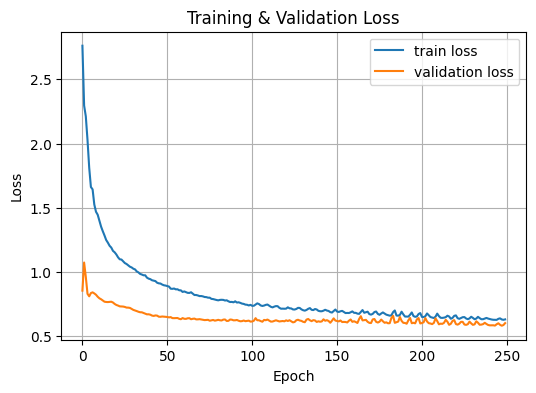

In [63]:
# Assuming x_train and y_train are your training data
history = model.fit(X_train, y_train, epochs=250, batch_size=40000, validation_data=(X_val, y_val))

# Plot training & validation loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
model.save("dense_800_200_acc_55")

INFO:tensorflow:Assets written to: dense_800_200_acc_55/assets


INFO:tensorflow:Assets written to: dense_800_200_acc_55/assets


-1.0


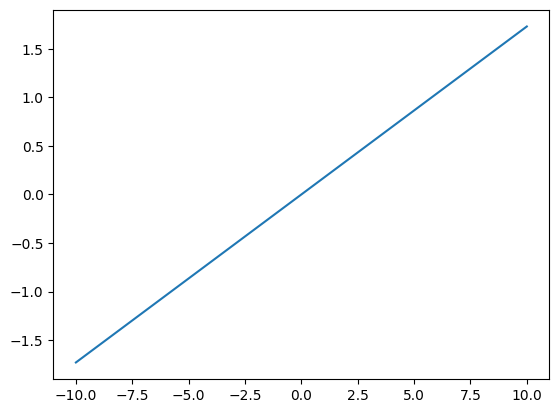

In [72]:
ind = 31
# print(np.min(X_val[ind]))
plt.plot(function_utils.XS, X_val[ind])
print(y_val[ind])

In [ ]:
# Round predictions
y_pred = tf.round(model(X_train))

# Convert to numpy arrays
y_pred = y_pred.numpy().astype(int).flatten()
y_true = y_train.astype(int).flatten()

# Compute totals per class (0..3 assumed)
n_classes = 4
tot = np.bincount(y_true + 1, minlength=n_classes)
correct = np.bincount(y_true[y_pred == y_true], minlength=n_classes)

# Class-wise accuracy
acc = correct / tot

acc

array([1.        , 0.40936721, 0.75298605, 0.00598146])

In [104]:
np.sum(y_train == 0) / y_train.shape[0]
# model(X_train[:100])

0.245